# Final Project: Apple Disease Classification
**Based on the Kaggle competition: [Apple Disease Classification](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview)**

### Setting up Env

In [3]:
import os
#using `pathlib.Path to work with paths in Python`
from pathlib import Path

if os.getenv("COLAB_RELEASE_TAG"):
  colab_flag = True
else:
  colab_flag = False

if colab_flag == True:
   print("Running in Colab...")
   #Install Kaggle API
   ! pip install -q kaggle
   #Install Huggingface Datasets lib
   ! pip install -q datasets
   #Install Huggingface transformers
   ! pip install -q transformers[torch]
   #Intall Timm for Pytorch Image Models
   ! pip install -q timm
   print("...Installed required dependencies")
else:
   print("Running in local environment...")

Running in Colab...
...Installed required dependencies


In [4]:
if colab_flag == True:
  import json
  from google.colab import drive
  drive.mount('/content/drive/')

  # Set the file path
  file_path = '/content/drive/MyDrive/dtu/fastAI/kaggle_api.json'

  # Check if the file exists
  if os.path.exists(file_path):
      # Load the JSON file
      with open(file_path) as f:
          creds = json.load(f)
      print('Sucesfully set kaggle credentials')
  else:
      # Handle the case when the file does not exist
      creds = None  # or any other appropriate action you want to take
      print('Error: File not found, Credentials NOT set')
else:
    import json
    file_path = "../secrets/kaggle_api.json"
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the JSON file
        with open(file_path) as f:
            creds = json.load(f)
        print('Sucesfully set kaggle credentials')
    else:
        # Handle the case when the file does not exist
        creds = None  # or any other appropriate action you want to take
        print('Error: File not found, Credentials NOT set')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Sucesfully set kaggle credentials


### Downloading the data

In [8]:
#Set path for the titanic dataset
path = Path('plant-pathology-2020-fgvc7')

if path.exists():
  print('Data folder exists')
else:
  print('Data not detected, starting download')
  #Setup of kaggle credentials to use the API for downloading dataset
  cred_path = Path('~/.kaggle/kaggle.json').expanduser()
  if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(json.dumps(creds))
    #If not Json
    #cred_path.write_text(creds)
    cred_path.chmod(0o600)
  import zipfile,kaggle
  #Download data
  kaggle.api.competition_download_cli(str(path))
  #Unzip at path
  zipfile.ZipFile(f'{path}.zip').extractall(path)

#Verifying the the local content
!ls {path}

Data folder exists
images	sample_submission.csv  small_images  test.csv  train.csv


In [9]:
import timm
from fastai.vision.all import *

image_path = path/'images'
image_files = get_image_files(image_path)

"""
train_path = path/'train'
train_files = get_image_files(train_path)

test_path = path/'test'
test_files = get_image_files(train_path)

"""

"\ntrain_path = path/'train'\ntrain_files = get_image_files(train_path)\n\ntest_path = path/'test'\ntest_files = get_image_files(train_path)\n\n"

In [ ]:
#Simply contains the filename of all the images in the given folder
image_files[0:3]

(#3) [Path('plant-pathology-2020-fgvc7/images/Test_550.jpg'),Path('plant-pathology-2020-fgvc7/images/Test_484.jpg'),Path('plant-pathology-2020-fgvc7/images/Test_708.jpg')]

Shape of image : (1365, 2048)


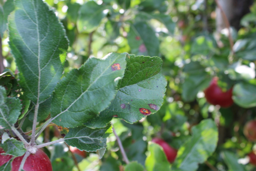

In [ ]:
img = PILImage.create(image_files[3])
print(f'Shape of image : {img.shape}')
img.to_thumb(256)

### Inspecting the image sizes


In [ ]:
import multiprocessing
from fastcore.parallel import *

n_cores = multiprocessing.cpu_count()
print(f'Number of cores {n_cores}')

def check_size(img):
    return PILImage.create(img).shape

"""
sizes = parallel(check_size, image_files, n_workers=n_cores)
pd.Series(sizes).value_counts()
"""

Number of cores 2


'\nsizes = parallel(check_size, image_files, n_workers=n_cores)\npd.Series(sizes).value_counts()\n'

In [ ]:
#sizes = parallel(check_size, test_files, n_workers=n_cores)
#pd.Series(sizes).value_counts()

The images are of similar size (1365 x 2048), but a few are rotated (2048x1365). To correct this we will create a new function that checks all images, and rotate those that are an exact transpose of the normal image-size. We may stil risk that the final test set contains images of a completely different size.

In [ ]:
#Function to load images, and if they are in the wrong orientation, rotate them and overwrite

#NOTE Should correct so that it doesn't flip the Test Images as well :-)

def check_transpose(img):
    img_loaded = PILImage.create(img)
    if img_loaded.shape == (2048,1365):
        print('Flipped image: ', img)
        #Transpose the image 90 degrees and overwrite the original image
        img_rotated = img_loaded.rotate(90, expand=True)
        #img_rotated.show()
        #Save the image
        img_rotated.save(img)
        return img_rotated.shape
    else:
        return img_loaded.shape

image_sizes = parallel(check_transpose, image_files, n_workers=n_cores)
print(f'Images size after rotation: {pd.Series(sizes).value_counts()}')

#test_sizes = parallel(check_transpose, test_files, n_workers=n_cores)
#print(f'Test images size after rotation: {pd.Series(sizes).value_counts()}')

Flipped image:  plant-pathology-2020-fgvc7/images/Train_1156.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_1672.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_744.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_1140.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_1390.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Train_245.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_430.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_1541.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_365.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_579.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_1337.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_277.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_311.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_1643.jpg
Flipped image:  plant-pathology-2020-fgvc7/images/Test_1191.jpg
Flipped image:  plant-pathology-2020-fgvc7/im

### Inspecting the labels and reformating label CSV

In [10]:
#Inspect the labels of the dataset by loading the csv file into a pandas dataframe
df_train = pd.read_csv(f'{path}/train.csv')
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [11]:
#Create a new column with decoded labels for each image based on the one-hot encoded labels by using the np.argmax() function on column 2 to 5
#Set the label string in the new label column as the column name where the value is 1

df_train['label'] = df_train.apply(lambda col: df_train.columns[1:5][np.argmax(col.values[1:5])], axis=1)
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [12]:
#path_full = 'plant-pathology-2020-fgvc7/images/'
#df_train['image_path'] = [path_full+image_id+".jpg" for image_id in df_train['image_id']]
#df_train.image_path[0]

In [ ]:
df_train.label.value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

As seen we have the multiple_diseases label under-represented in the training set. Later on I will try to augment the training set with more images of multiple_diseases.

### Setting up dataloader

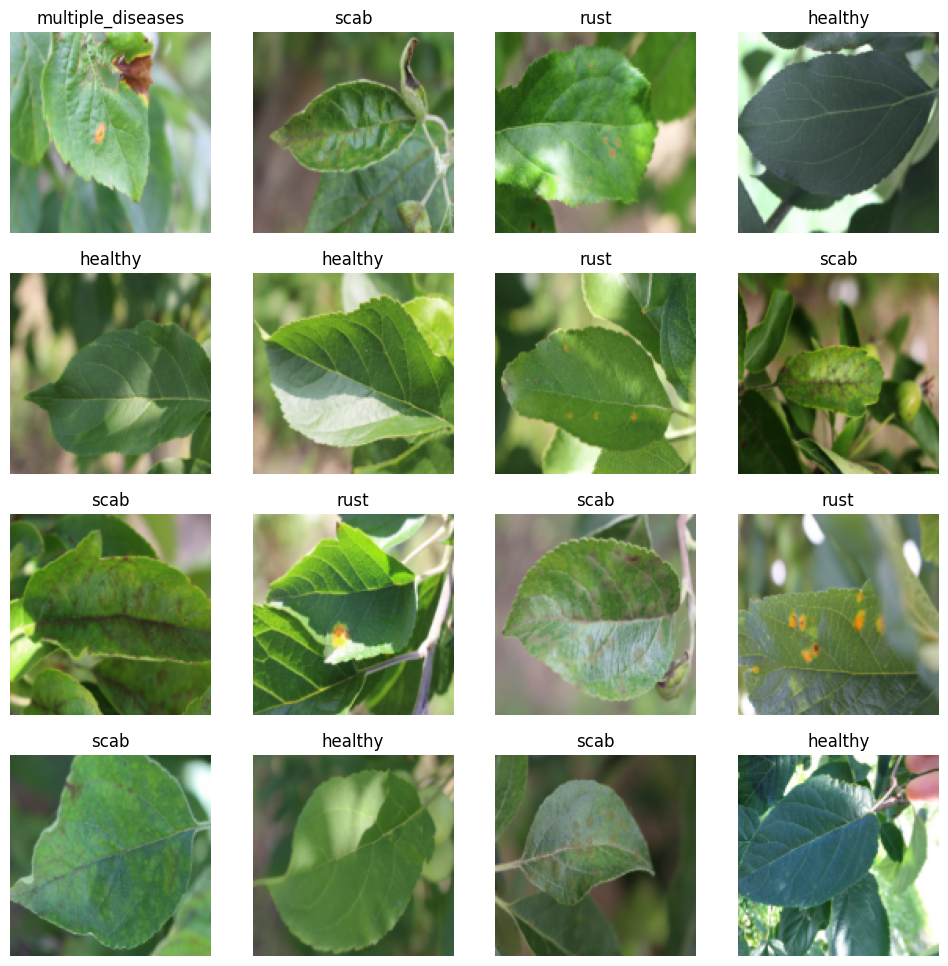

In [ ]:
#For Some reason simply adding .jpg to the image_path column doesn't work with the dataloader, so we will use the fastai function to add the suffix instead
#It seems odd that the full path both has to be specified in the fn_column, and that the folder also has to be specified in the folder parameter, but it does not work otherwise..
#When using .from_df it seems like fn_column strictly needs to be the file name, and the folder structure and prefeix needs to be specified in the other parameters

dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'images',
                               suff='.jpg',
                               bs=16,
                               item_tfms=Resize(256, method='squish'),
                               batch_tfms=aug_transforms(size=128, min_scale=0.75),
                               )
dls.show_batch(max_n=16)

# Setting up a simple model
Using convext_tiny, trained on the 22k imagenet

In [ ]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate, path='.').to_fp16()

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


SuggestedLRs(valley=0.0012022644514217973, slide=0.0008317637839354575)

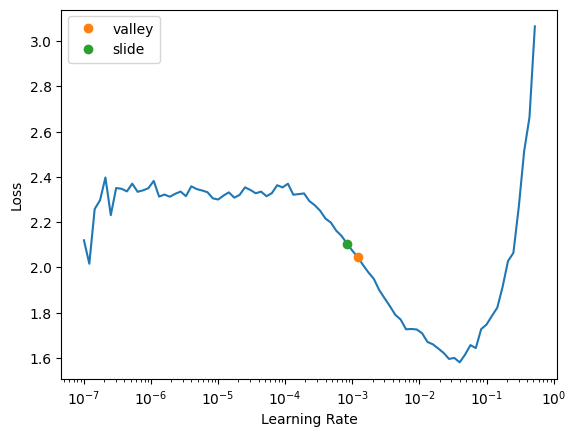

In [ ]:
#Searching for an appropriate learning rate
learn.lr_find(suggest_funcs=(valley, slide))

Generally speaking the reccomendations from fastAI is conservative to be on the safe side, so typically one can select a higher LR to speed up the process, as long as one is not too close at the party where LR is too high and we end up overstepping.

In [ ]:
#3 epochs, LR= 10^-2
learn.fine_tune(3, 0.005)
#fine_tune = combination of fit_one_cycle(s) + (un)freeze(s) that is found to work well in most fine-tune scenarios.

epoch,train_loss,valid_loss,error_rate,time
0,0.915308,0.647695,0.145604,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.541824,0.312039,0.118132,01:21
1,0.368757,0.252789,0.079670,01:16
2,0.239614,0.199249,0.060440,01:18


In [ ]:
#3 epochs, LR= 10^-2
learn.fine_tune(20, 0.005)
#fine_tune = combination of fit_one_cycle(s) + (un)freeze(s) that is found to work well in most fine-tune scenarios.

epoch,train_loss,valid_loss,error_rate,time
0,0.264354,0.361882,0.085165,01:18


epoch,train_loss,valid_loss,error_rate,time
0,0.210346,0.229326,0.063187,01:19
1,0.167066,0.191571,0.043956,01:17
2,0.156327,0.218918,0.046703,01:20
3,0.161126,0.246923,0.041209,01:17
4,0.136856,0.274175,0.057692,01:16
5,0.149375,0.329957,0.079670,01:19
6,0.157705,0.286881,0.060440,01:18
7,0.111733,0.227054,0.063187,01:15
8,0.088158,0.217944,0.049451,01:23
9,0.079000,0.275753,0.057692,01:18


At this point, fine-tuning more epochs does not increase accuracy after roughly 3 epochs

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,0.925226,0.555016,0.156593,01:19


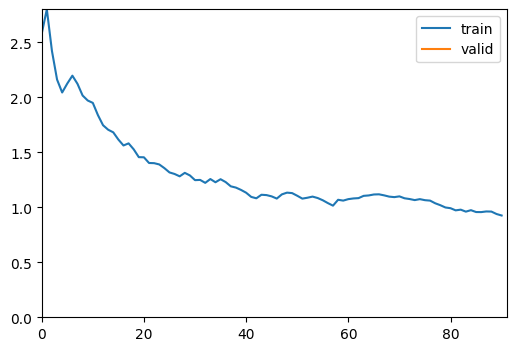

epoch,train_loss,valid_loss,error_rate,time
0,0.444961,0.337489,0.085165,01:16
1,0.422110,0.313457,0.068681,01:19
2,0.296060,0.337896,0.082418,01:21
3,0.157494,0.207814,0.038462,01:23
4,0.083578,0.203241,0.041209,01:22


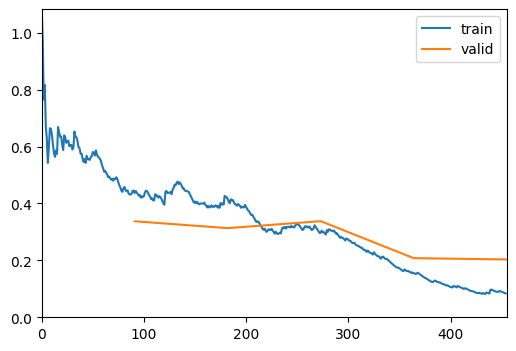

In [ ]:
learn2 = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate, path='.').to_fp16()
learn2.fine_tune(5, 0.01, cbs=[ShowGraphCallback()])

# Preprocessing experiments

## Resizing images
The image_tfms are applied every time we call model_train and due to the large size of images and the limited (2 core) CPU of Google Colab, the iteration process is very slow and has to be called on every model train.

Instead I will resize all the images and save these so that they can be re-used

In [13]:
import multiprocessing
from fastcore.parallel import *

n_cores = multiprocessing.cpu_count()
print(f'Number of cores {n_cores}')

def check_size(img):
    return PILImage.create(img).shape

Number of cores 2


In [14]:
"""
dest = path/'small_images'
resize_images(path/'images', max_size=400, dest=dest, recurse=True)

#Save resized images to drive for fast reload in new instance
Copy images from path/small_images to /content/drive/MyDrive/dtu/fastAI/10_final_project
!cp -r '/content/plant-pathology-2020-fgvc7/small_images' /content/drive/MyDrive/dtu/fastAI/10_final_project
"""
#Copy prev resized images from drive to Colab
#Create new folder in /content/plant-pathology-2020-fgvc7/small_images
!mkdir /content/plant-pathology-2020-fgvc7/small_images
!cp -r /content/drive/MyDrive/dtu/fastAI/10_final_project/small_images/. '/content/plant-pathology-2020-fgvc7/small_images'

#Check the size of a photo in the small_images
image_path_small = path/'small_images'
image_files_small = get_image_files(image_path_small)
sizes = parallel(check_size, image_files_small, n_workers=n_cores)

pd.Series(sizes).value_counts()


mkdir: cannot create directory ‘/content/plant-pathology-2020-fgvc7/small_images’: File exists


(266, 400)    10926
dtype: int64

## Variations image resizing (pre-processing)

There seem to be no one best-practice , https://datascience.stackexchange.com/questions/38758/should-i-pad-zero-or-mean-value-in-a-convolution-neural-network-what-about-refl
but generally cropping to square and using reflection as padding if needed seem to be the best rule-of-thumb to scew the data the least https://dev.to/sally20921/padding-in-neural-network-o8m |

Resize 'crop': By default, FastAI resize the image while keeping its original ratio so that the smaller size corresponds to the given size.By default FastAI then takes a crop ( ResizeMethod.CROP ). You can choose to resize the image while keeping its original ratio so that the bigger size corresponds to the given size, then take a pad ( ResizeeMethod.PAD ). Another way is to just squish the image to the given size ( ResizeeMethod.SQUISH ).

In [12]:
#Function for easily swapping item transform and aug
def train_model(arch, item, batch, epochs=5, learning_rate=0.005):
  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=item,
                               batch_tfms=batch,
                               )
  learn = vision_learner(dls,arch,metrics=error_rate).to_fp16()
  learn.fine_tune(epochs,learning_rate, cbs=[ShowGraphCallback()])
  return learn, dls


Function for collecting and emptying GPU Cache

In [18]:
!pip install pynvml
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

report_gpu()

GPU:0
process    3386171 uses     9100.000 MB GPU memory


#### **Cropping images: Valid_loss: 0.25, when re-run 0.25**
Method: Crop images to squares. Since we are relying on pre-trained models that are trained on square images (typically 224x224, ,256x256, 299x299 etc.), we will stick with a square cropping.


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.024041,0.693518,0.162088,00:08


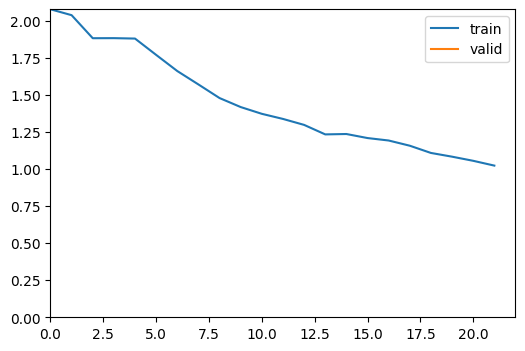

epoch,train_loss,valid_loss,error_rate,time
0,0.462388,0.401729,0.115385,00:11
1,0.423576,0.371493,0.098901,00:12
2,0.357743,0.273696,0.074176,00:11
3,0.300726,0.264645,0.074176,00:10
4,0.242083,0.256120,0.074176,00:12


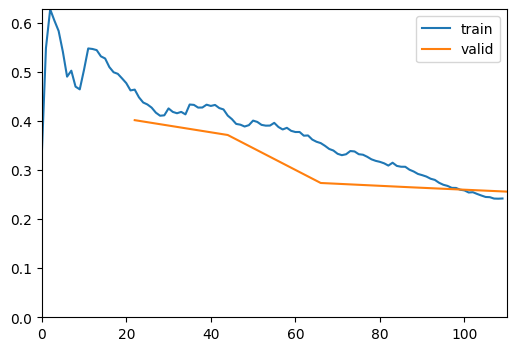

GPU:0
process       2872 uses     6738.000 MB GPU memory


In [ ]:
learn,dls = train_model('convnext_small_in22k',
                    item=Resize(256, method='crop'),
                    batch=aug_transforms(size=128, min_scale=0.75),
                    epochs=5)
report_gpu()

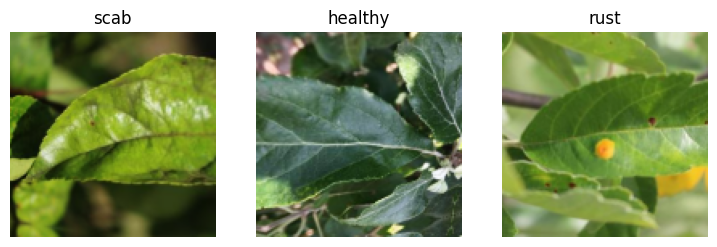

In [ ]:
dls.show_batch(max_n=3)

#### **Squishing images: Valid_loss: 0.30... When re-run: 0.16**
Method: Squish images to squares

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.066402,0.716292,0.186813,00:09


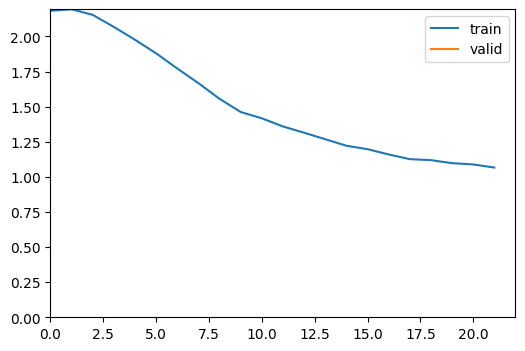

epoch,train_loss,valid_loss,error_rate,time
0,0.491709,0.319613,0.112637,00:12
1,0.392354,0.357283,0.098901,00:12
2,0.303511,0.212769,0.074176,00:10
3,0.238710,0.164619,0.068681,00:12
4,0.191054,0.158894,0.082418,00:12


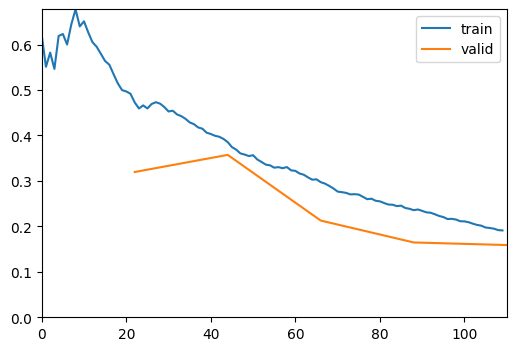

GPU:0
process       2872 uses     5884.000 MB GPU memory


In [ ]:
learn,dls = train_model('convnext_small_in22k',
                    item=Resize(256, method='squish'),
                    batch=aug_transforms(size=128, min_scale=0.75),
                    epochs=5)
report_gpu()

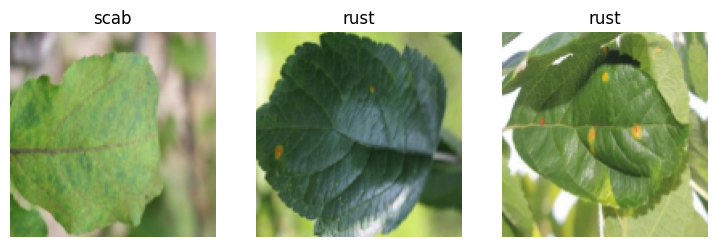

In [ ]:
dls.show_batch(max_n=3)

Squishing seem to provide poorer results than cropping

#### **Adding padding (reflection): Valid_loss: 0.28, when re-run 0.35**

Method: Resize image by adding padding to the images (not square in train/test samples), and add reflection as the padding pixels. From my own logic, this might seem like the best option as it preserved the full information of the original images and a reflection of the leaves would not seem to create a too unrealistic result.

In reality, worst result.

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.270744,0.809383,0.200549,00:11


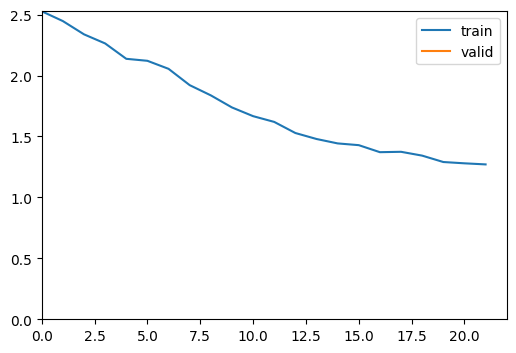

epoch,train_loss,valid_loss,error_rate,time
0,0.574871,0.429133,0.134615,00:13
1,0.456617,0.407915,0.123626,00:13
2,0.352153,0.288914,0.098901,00:12
3,0.278356,0.287273,0.096154,00:11
4,0.222949,0.282150,0.098901,00:13


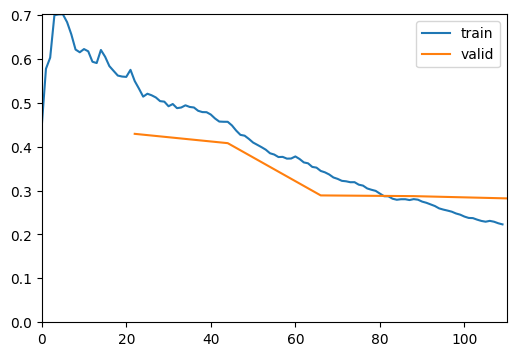

GPU:0
process       2872 uses     6772.000 MB GPU memory


In [ ]:
learn,dls = train_model('convnext_small_in22k',
                    item=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Reflection),
                    batch=aug_transforms(size=128, min_scale=0.75),
                    epochs=5)

report_gpu()

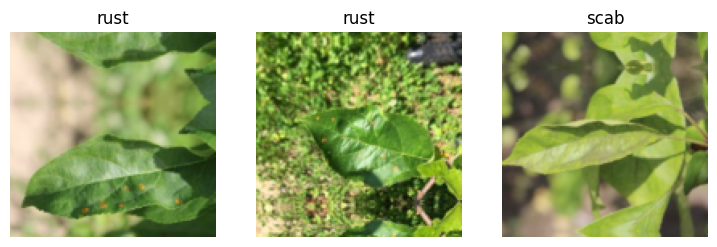

In [ ]:
dls.show_batch(max_n=3)

Not very good results :-) To inspect the result of the reflection augmentation prior applying the aug_tfms:

In [ ]:
  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Reflection)
  )

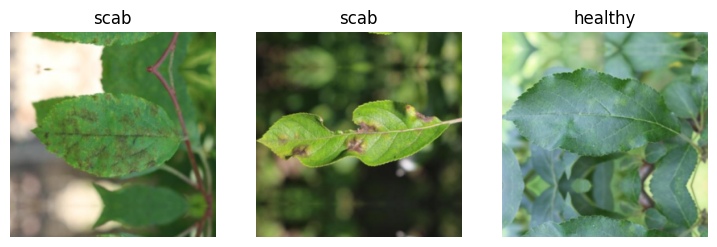

In [ ]:
dls.show_batch(max_n=3)

#### **Maintaining image dimension: Valid_loss: 0.29, when re-run 0.21**
Method: Don't resize image to square, but instead feed the original image ratio (1.33), and if an image input has another ratio padd these with reflections as padding pixels. Suposedly not ideal since the pretrained models are trained on square images.

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.138725,0.504975,0.131868,00:09


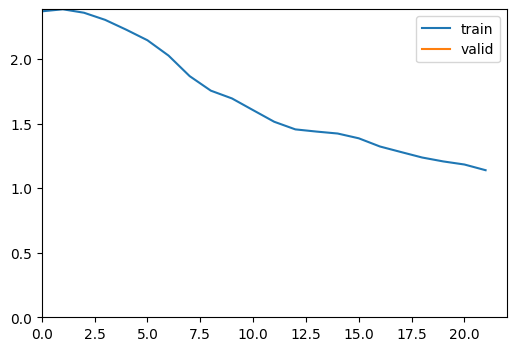

epoch,train_loss,valid_loss,error_rate,time
0,0.411086,0.302828,0.093407,00:12
1,0.324037,0.352624,0.093407,00:12
2,0.262263,0.229848,0.079670,00:10
3,0.211111,0.220012,0.068681,00:12
4,0.173470,0.215667,0.068681,00:12


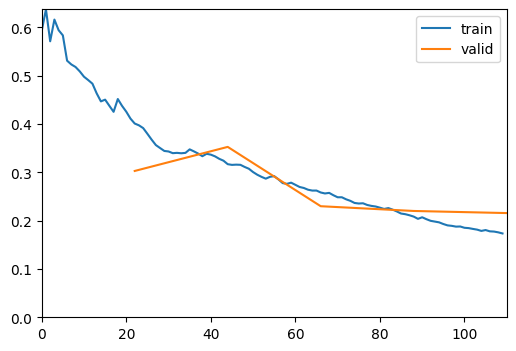

GPU:0
process       2872 uses     6764.000 MB GPU memory


In [ ]:
learn,dls = train_model('convnext_small_in22k',
                    item=Resize((170,256), method=ResizeMethod.Pad, pad_mode=PadMode.Reflection),
                    batch=aug_transforms(size=128, min_scale=0.75),
                    epochs=5)

report_gpu()

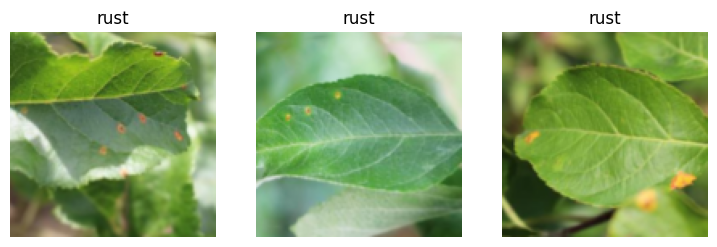

In [ ]:
dls.show_batch(max_n=3)

#### **Initial resulsts: Cropping**
Initial analysis showed best result with simple cropping or including the original image dimension. However, it is also clear that variations are large from run to run, and it might be needed to do multiple runs with W&B logging to do any meaningfull conclusions.

However, it does not seem to hurt to simply proceed with the "rule of thumb" which is to crop to a square image.

# Introducing W&B
## Testing resizing methods

In [15]:
pip install -Uq wandb

In [16]:
# Silence Wandb printouts
os.environ["WANDB_SILENT"] = "true"

import wandb
from fastai.callback.wandb import *

In [31]:
#Function for easily swapping item transform and aug
def train_model(arch, item, batch, epochs=5, learning_rate=0.005):

  wandb.init(project='apple_disease', entity='jealk')

  wandb.config.update({
      'arch': arch,
      'item_tfms_size': str(item.size),
      'item_tfms_method': item.method,
      'item_tfms_padding': item.pad_mode,
      'learning_rate': learning_rate,
      'epochs': epochs,
  })

  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=item,
                               batch_tfms=batch,
                               )
  learn = vision_learner(dls,arch,metrics=error_rate).to_fp16()
  #Log preds = save 32 (default) preds incl thumb. to W&B
  learn.fine_tune(epochs,learning_rate, cbs=WandbCallback(log=None,log_preds=False,log_model=False))

  wandb.finish()
  return learn, dls

In [33]:
resize_methods = [Resize(256, method='crop'),
                  Resize(256, method='squish'),
                  Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Reflection),
                  Resize((170,256), method=ResizeMethod.Pad, pad_mode=PadMode.Reflection)]


for resize_n in resize_methods:
  arch = 'convnext_small.fb_in22k'
  learn,dls = train_model(arch,
                    item=resize_n,
                    batch=aug_transforms(size=128, min_scale=0.75),
                    epochs=5)
  report_gpu()

wandb.finish()

epoch,train_loss,valid_loss,error_rate,time
0,1.084450,0.444279,0.120879,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.469013,0.366050,0.112637,00:12
1,0.402480,0.338371,0.096154,00:09
2,0.311763,0.228339,0.071429,00:13
3,0.271007,0.188817,0.065934,00:11
4,0.234564,0.190280,0.076923,00:11


GPU:0
process       1925 uses     5902.000 MB GPU memory


epoch,train_loss,valid_loss,error_rate,time
0,1.118389,0.788132,0.173077,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.431454,0.426068,0.120879,00:11
1,0.361788,0.386832,0.085165,00:12
2,0.275516,0.314789,0.085165,00:10
3,0.204037,0.265198,0.082418,00:12
4,0.170901,0.261745,0.082418,00:13


GPU:0
process       1925 uses     5888.000 MB GPU memory


epoch,train_loss,valid_loss,error_rate,time
0,1.110368,0.869646,0.189560,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.542603,0.566997,0.170330,00:14
1,0.434088,0.571492,0.156593,00:12
2,0.343924,0.516701,0.131868,00:11
3,0.275717,0.442783,0.126374,00:18
4,0.232417,0.426137,0.120879,00:18


GPU:0
process       1925 uses     5882.000 MB GPU memory


epoch,train_loss,valid_loss,error_rate,time
0,1.024557,0.679170,0.148352,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.428394,0.372519,0.112637,00:12
1,0.343291,0.334243,0.098901,00:15
2,0.280579,0.294430,0.076923,00:11
3,0.212323,0.266449,0.082418,00:10
4,0.172996,0.258875,0.082418,00:13


GPU:0
process       1925 uses     5890.000 MB GPU memory


## Testing different models
Using W&B

In [45]:
#Function for easily swapping item transform and aug
#Added early stopping for longer train runs
def train_model(arch, item, batch, epochs, learning_rate=0.005):

  config = {
      'arch': arch,
      'item_tfms_size': str(item.size),
      'item_tfms_method': item.method,
      'item_tfms_padding': item.pad_mode,
      'learning_rate': learning_rate,
      'epochs': epochs,
  }

  wandb.init(project='apple_disease', entity='jealk', group='model_architecture', config=config)

  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=item,
                               batch_tfms=batch,
                               )
  learn = vision_learner(dls,arch,metrics=error_rate).to_fp16()
  #Log preds = save 32 (default) preds incl thumb. to W&B
  early_stopping_cb = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0, patience=3)

  learn.fine_tune(epochs,learning_rate, cbs=[WandbCallback(log=None,log_preds=False,log_model=False),early_stopping_cb])

  wandb.finish()
  return learn, dls

In [46]:
# in22ft1k means pretrain on imagetnet 22k and fintune in 1K, in22k means only train on imagenet 22k
# Hmm how does that impact finetuning, does fastAI per default cut off the last finetune layer anyway to replace it or?
# I should look further into this..

model_archs = ['convnext_small.fb_in22k',
               'vit_small_patch16_224.augreg_in21k_ft_in1k',
               'resnetrs50.tf_in1k',
               'inception_resnet_v2.tf_in1k',
               'beitv2_base_patch16_224.in1k_ft_in22k']

for model in model_archs:
  arch = model
  learn,dls = train_model(arch,
                    item=Resize(256, method='crop'),
                    batch=aug_transforms(size=224, min_scale=0.75),
                    epochs=15)
  report_gpu()

wandb.finish()

epoch,train_loss,valid_loss,error_rate,time
0,1.175846,0.542039,0.137363,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.511832,0.340584,0.074176,00:17
1,0.463858,0.256788,0.071429,00:17
2,0.360202,0.222868,0.063187,00:17
3,0.308206,0.226386,0.068681,00:17
4,0.278499,0.165004,0.041209,00:18
5,0.247276,0.183993,0.060440,00:17
6,0.219608,0.196874,0.049451,00:17
7,0.188111,0.171515,0.052198,00:16


No improvement since epoch 4: early stopping
GPU:0
process       1925 uses    10248.000 MB GPU memory


epoch,train_loss,valid_loss,error_rate,time
0,1.272878,0.522751,0.093407,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.466690,0.358777,0.085165,00:09
1,0.362355,0.241969,0.065934,00:12
2,0.313561,0.162142,0.049451,00:10
3,0.263685,0.243861,0.068681,00:10
4,0.222257,0.253340,0.057692,00:12
5,0.198613,0.191360,0.046703,00:09
6,0.172879,0.177046,0.054945,00:12
7,0.147504,0.205815,0.046703,00:09
8,0.131010,0.169035,0.038462,00:11
9,0.112850,0.200388,0.046703,00:10


No improvement since epoch 8: early stopping
GPU:0
process       1925 uses     6202.000 MB GPU memory


epoch,train_loss,valid_loss,error_rate,time
0,1.091195,0.715950,0.186813,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.625896,0.435915,0.129121,00:13
1,0.495214,0.421572,0.107143,00:13
2,0.465456,0.452954,0.118132,00:12
3,0.407977,0.403271,0.112637,00:14
4,0.361921,0.399179,0.115385,00:13


No improvement since epoch 1: early stopping
GPU:0
process       1925 uses     7628.000 MB GPU memory


epoch,train_loss,valid_loss,error_rate,time
0,1.361412,1.315276,0.296703,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.850129,0.778331,0.197802,00:19
1,0.728182,0.717700,0.192308,00:18
2,0.654691,0.607075,0.181319,00:18
3,0.582275,0.607530,0.178571,00:18
4,0.520828,0.568199,0.151099,00:19
5,0.464427,0.494095,0.142857,00:19
6,0.404528,0.479759,0.140110,00:18
7,0.358052,0.444221,0.115385,00:18
8,0.304830,0.493845,0.126374,00:19
9,0.257451,0.433998,0.112637,00:20


No improvement since epoch 9: early stopping
GPU:0
process       1925 uses     6284.000 MB GPU memory


epoch,train_loss,valid_loss,error_rate,time
0,1.223775,0.289880,0.082418,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.375326,0.198374,0.057692,00:22
1,0.297905,0.135097,0.041209,00:23
2,0.240280,0.111960,0.043956,00:22
3,0.208334,0.234172,0.076923,00:21
4,0.184998,0.094934,0.027473,00:22
5,0.167355,0.127328,0.041209,00:23
6,0.150469,0.152807,0.027473,00:22
7,0.129576,0.103273,0.024725,00:21
8,0.104260,0.125579,0.032967,00:24
9,0.080976,0.119627,0.027473,00:24


No improvement since epoch 7: early stopping
GPU:0
process       1925 uses     9900.000 MB GPU memory


# Larger models
## Utilizing gradient accumulation

To improve performance a next step is to work with larger model sizes, but as the models above already use upwards of 10GB of the 15 GB available on Colab, we will have to introduce gradient accumulation to reduce the memory need for training.

Based on the prelimenary result the best performing options are:
- Pre processing by cropping to square
- Model architecture: Beit, closely followed by VIT and ConvNext. Resnet and Inception performs poorly (both is also just trained on 1K imagenet, the others on 22k)

In [1]:
#Function for easily swapping item transform and aug
#Added early stopping for longer train runs
def train_model(arch, item, batch, batch_size, epochs, learning_rate=0.005, accum_steps=1):

  config = {
      'arch': arch,
      'item_tfms_size': str(item.size),
      'item_tfms_method': item.method,
      'item_tfms_padding': item.pad_mode,
      'learning_rate': learning_rate,
      'epochs': epochs,
  }

  wandb.init(project='apple_disease', entity='jealk', group='large_model_architecture', config=config)

  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=item,
                               bs=batch_size//accum_steps,
                               batch_tfms=batch,
                               )
  learn = vision_learner(dls,arch,metrics=error_rate).to_fp16()

  early_stopping_cb = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0, patience=3)

  gradient_accumulation_cb = GradientAccumulation(accum_steps) if accum_steps > 1 else []

  learn.fine_tune(epochs,learning_rate, cbs=[WandbCallback(log=None,log_preds=False,log_model=False),early_stopping_cb, gradient_accumulation_cb])

  wandb.finish()
  return learn, dls


In [20]:
#Model arch + accum steps needed to fit on GPU

model_archs = [('convnext_large.fb_in22k',3),
               ('vit_large_patch16_224.augreg_in21k',4),
               ('beitv2_large_patch16_224.in1k_ft_in22k',3)]

for model in model_archs:
  arch = model
  learn,dls = train_model(arch[0],
                    item=Resize(256, method='crop'),
                    batch=aug_transforms(size=224, min_scale=0.75),
                    batch_size = 64,
                    epochs=5,
                    accum_steps=arch[1])
  report_gpu()

wandb.finish()

epoch,train_loss,valid_loss,error_rate,time
0,0.840144,0.666113,0.140110,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.403452,0.260568,0.079670,00:39
1,0.410516,0.371898,0.115385,00:43
2,0.287876,0.240728,0.060440,00:40
3,0.168277,0.209815,0.063187,00:41
4,0.128437,0.199562,0.060440,00:41


GPU:0
process    3386171 uses    12310.000 MB GPU memory


epoch,train_loss,valid_loss,error_rate,time
0,0.753831,0.502118,0.104396,00:34


epoch,train_loss,valid_loss,error_rate,time


OutOfMemoryError: ignored